# Домашнее задание №3

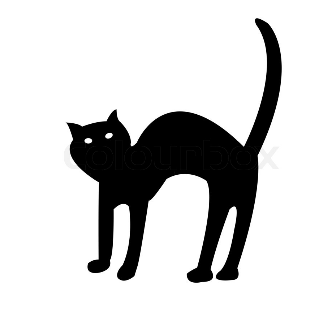

In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline

def show_gray(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap="gray")

def show_rgb(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show(img):
    if img.ndim == 3:
        show_rgb(img)
    else:
        show_gray(img)
        

cat = cv2.imread("cat.jpg")
show(cat)

In [2]:
def generate_circle_mask(n):
    b = 2
    struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n, n))
    return cv2.copyMakeBorder(struct, b, b, b, b, cv2.BORDER_CONSTANT, 0)

def find_figure_picture(src, fig):
    w = cv2.dilate(fig, np.ones((3,3), np.uint8))
    a = cv2.erode(src, fig)
    b = cv2.erode(255 - src, cv2.bitwise_xor(w, fig))
    return cv2.bitwise_and(a, b)

def find_circle_picture(src, n):
    return find_figure_picture(src, generate_circle_mask(n))

def find_circle(src, n):
    return find_figure(src, generate_circle_mask(n))

def find_figure(src, fig):
    img = find_figure_picture(src, fig)
    return np.where(img != 0)

def extract(cmp):
    border = 2
    cmp = cmp[:, np.any(cmp != 0, axis=0)]
    cmp = cmp[~np.all(cmp == 0, axis=1)]
    p = np.zeros((cmp.shape[0] + border * 2, cmp.shape[1] + 2 * border), np.uint8)
    p[border:cmp.shape[0]+border, border:border+cmp.shape[1]] = cmp
    return p

**1. (3 балла)** Выделите границы на изображении portrait.jpg:

• при помощи градиента,

• при помощи лапласиана,

• с помощью морфологической обработки.                                                         

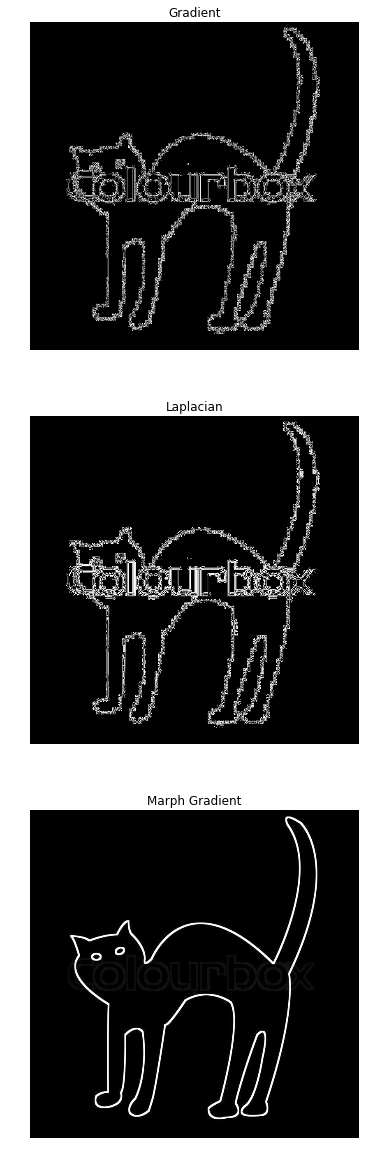

In [3]:
img = cv2.imread("portrait.jpg")
grad = (np.abs(np.gradient(img, axis=0)) + np.abs(np.gradient(img, axis=1))).astype(np.float32)
laplacian = cv2.Laplacian(img, cv2.CV_32F)
morph = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, np.ones((5,5),np.uint8))

images = [grad, laplacian, morph]
titles = ['Gradient', 'Laplacian', 'Marph Gradient']
fig, axs = plt.subplots(nrows=3, figsize=(10,20))
for i in range(len(images)):
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])
plt.show()



**2. (4 балла)** Реализуйте двухпроходный алгоритм выделения компонент связности на бинарном изображении. Значение фона (0 или 1) и структурный элемент передавайте в качестве параметра.

In [4]:
def compound_components(src, struct_mat, background):
    from collections import defaultdict
    w, h = src.shape[0], src.shape[1]
    w1, h1 = struct_mat.shape[0], struct_mat.shape[1]
    w2, h2 = w1 // 2, h1 // 2
    groups = np.zeros((w + w1, h + h1)).astype(int)
    counter, up, rank = 0, defaultdict(int), defaultdict(int)
    
    def make_set(v):
        up[v], rank[v] = v, 0
    
    def find_set(v):
        if v == up[v]:
            return v
        else:
            up[v] = find_set(up[v])
            return up[v]
    
    def union_set(x, y):
        x, y = find_set(x), find_set(y)
        if x != y:
            if rank[x] < rank[y]:
                x, y = y, x
            up[y] = x
            if rank[x] == rank[y]:
                rank[x] += 1

    for x in range(w):
        for y in range(h):
            if src[x][y] != background:
                g = groups[x:x+w1,y:y+h1] * struct_mat
                fg = list(filter(lambda x: x != 0, g.ravel()))
                if not fg:
                    counter += 1
                    groups[w2 + x][h2 + y] = counter
                    make_set(counter)
                else:
                    groups[w2 + x][h2 + y] = fg[0]
                    for a in fg:
                        for b in fg:
                            union_set(a, b)

    groupToComponent, color = np.zeros(counter + 1).astype(int), 1
    for i in range(1, counter + 1):
        m = find_set(i)
        if groupToComponent[m] == 0 :
            groupToComponent[m] = color
            color += 1
        groupToComponent[i] = groupToComponent[m]
    components = defaultdict(list)
    for x in range(w):
        for y in range(h):
            if src[x][y] != background:
                t = groupToComponent[groups[w2 + x][h2 + y]]
                components[t].append((x, y))
    return components.values()

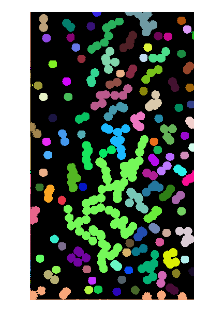

In [5]:
struct = np.ndarray(shape=(3,3), buffer=np.array([[0,1,0],[1,1,1],[0,1,0]]), dtype=int)

img = cv2.imread("circles.jpg", 0)
img = np.vectorize(lambda x: 0 if x < 50 else 255, otypes=[np.uint8])(img)
comps = compound_components(img, struct, 0)
res = np.zeros((img.shape[0], img.shape[1],3)).astype(np.uint8)
from random import randint
for i, component in enumerate(comps):
    color = np.array([randint(0, 255), randint(0, 255), randint(0, 255)],dtype=np.uint8)
    for x,y in component:
        res[x][y] = color
show(res)

**3. (5 баллов)** Выделите в изображении $table.jpg$ границы таблицы с использова- нием морфологических операций. Результатом обработки должно быть изображение, в котором удален весь текст и оставлены только границы таблицы

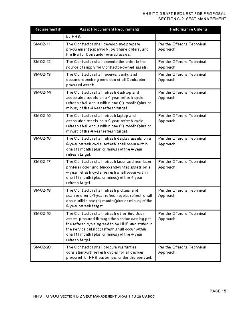

In [6]:
table = cv2.imread("table.jpg")
show(table)

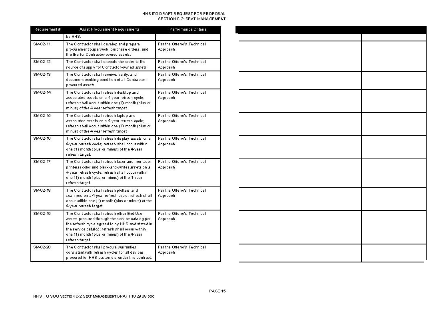

In [7]:
table = cv2.imread("table.jpg", 0)
kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)

def substract_black(a, b):
    w,h = a.shape[0], a.shape[1]
    c = np.copy(a)
    for x in range(w):
        for y in range(h):
            if b[x][y] < 50:
                c[x][y] = 255
    return c

def f(img):
    img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1]
    tmp = cv2.dilate(cv2.morphologyEx(table, cv2.MORPH_TOPHAT, kernel), kernel, iterations=4)
    almost = substract_black(table, 255 - tmp)
    almost = cv2.threshold(almost, 128, 255, cv2.THRESH_BINARY)[1]
    x = 255 - almost
    result = 255 - cv2.morphologyEx(x, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8), iterations=1)
    result = 255 - cv2.morphologyEx(255 - result, cv2.MORPH_CLOSE, np.ones((5, 5), dtype=np.uint8), iterations=3)
    return cv2.threshold(result, 128, 255, cv2.THRESH_BINARY)[1]

morph = f(table)
cv2.imwrite("3.png", np.hstack((table, morph)))
show(np.hstack((table, morph)))

**4. (7 баллов)** Для изображения $circles.jpg$ реализуйте морфологический алгоритм для построения трех изображений, которые бы содержали соответственно:

• только частицы, касающиеся краев изображения, 

• только группы перекрывающихся частиц,

• только одиночные круглые частицы.

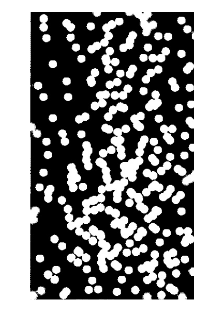

In [8]:
circles = cv2.imread("circles.jpg")
show(circles)


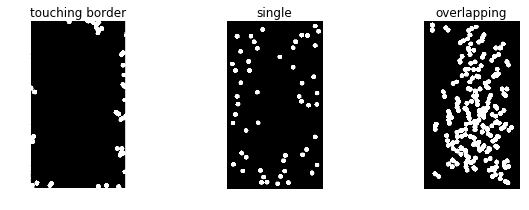

In [9]:
b = 2
original = cv2.imread("circles.jpg", 0)
img = cv2.copyMakeBorder(original, b, b, b, b, cv2.BORDER_CONSTANT, value=255)
img = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]
struct = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
comps = compound_components(img, struct, 0)
w,h = img.shape[0], img.shape[1]

for cmp in comps:
    if (0, 0) in cmp:
        touching_border = np.zeros((w, h), np.uint8)
        for x,y in cmp:
            touching_cmp = cmp
            touching_border[x][y] = 255
        break

from collections import Counter
size_counter = Counter([len(x) for x in comps if x != touching_cmp])

most_common = size_counter.most_common(1)[0][0] + 30
        
single_cmps = [cmp for cmp in comps if len(cmp) < most_common]
intersected_cmps = [cmp for cmp in comps if len(cmp) >= most_common and cmp != touching_cmp]

single_circles = np.zeros((w, h), np.uint8)
for cmp in single_cmps:
    for x,y in cmp:
        single_circles[x][y] = 255

intersected_circles = np.zeros((w, h), np.uint8)
for cmp in intersected_cmps:
    for x,y in cmp:
        intersected_circles[x][y] = 255

images = [touching_border, single_circles, intersected_circles]
titles = ['touching border', 'single', 'overlapping']
fig, axs = plt.subplots(ncols=3, figsize=(10,3))
for i in range(len(images)):
    axs[i].axis('off')
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(titles[i])
plt.show()


**5. (5 баллов) ** Отделите монеты от фона на изображении $coins\_1.jpg$, отсортируйте монеты по убыванию размера. Сгенерируйте результирующее изображение с цветной разметкой областей, соответствующих монетам на исходном изображении: на черном фоне должны быть выделены разными цветами области, соответствующие монетам. В центре каждой выделенной области разместите порядковый номер монеты в соответствии с сортировкой монет по размеру (в центре области, соответствующей самой большой монете, должно стоять число 1)

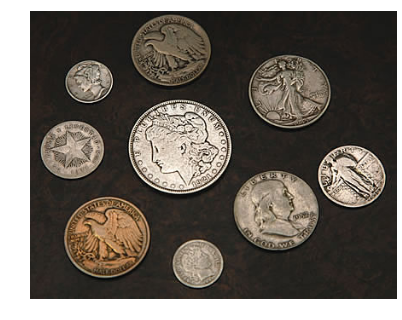

In [10]:
coins_1 = cv2.imread("coins_1.jpg")
show(coins_1)

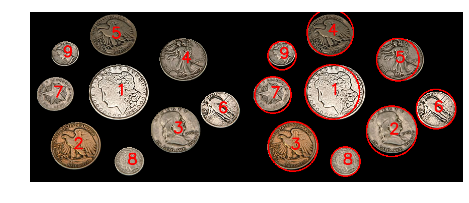

In [11]:
def hough_solution(original, gray):
    cimg = np.copy(original)
    img = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)[1]
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((6, 6), dtype=np.uint8), iterations=1)
    w,h = img.shape[0], img.shape[1]
    for x in range(w):
        for y in range(h):
            if img[x][y] == 0:
                cimg[x][y] = np.array([0, 0, 0]).astype(np.uint8)
    img = cv2.GaussianBlur(img,(5, 5), 9)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30)
    circles = np.uint16(np.around(circles))[0, :]
    circles = reversed(sorted([(r, cx, cy) for cx, cy, r in circles]))
    for i, (r, cx, cy) in enumerate(circles):
        cv2.putText(cimg, str(i + 1), (cx - 5, cy + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
        cv2.circle(cimg,(cx, cy), r,(0,0,255), 2)
        
    return cimg


def morph_solution(original, gray):
    cimg = np.copy(original)
    img = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)[1]
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((8, 8), dtype=np.uint8), iterations=1)
    w,h = img.shape[0], img.shape[1]

    for x in range(w):
        for y in range(h):
            cimg[x][y] = np.array([0, 0, 0]).astype(np.uint8)

    def listFig(img, cmps):
        res = []
        for c in cmps:
            cmp = np.zeros((w, h), np.uint8)
            for x,y in c:
                cmp[x][y] = 255
            res.append(cmp)
        return res

    cmps = compound_components(img, np.ones((3,3), np.uint8), 0)
    unextrcted_figures = listFig(img, cmps)
    figures = [extract(f) for f in unextrcted_figures]

    figures = sorted(figures, key=lambda x: x.sum(), reverse=True)
    centers = [find_figure(img, f) for f in figures]
    i = 1
    cimg = np.copy(original)
    for x in range(w):
        for y in range(h):
            cimg[x][y] = np.array([0, 0, 0]).astype(np.uint8)
    for cmp in cmps:
        for x,y in cmp:
            cimg[x][y] = original[x][y]

    for xs, ys in centers:
        for x, y in zip(xs, ys):
            cv2.putText(cimg, str(i), (y - 5, x + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
            i += 1

    return cimg

coins_1 = cv2.imread("coins_1.jpg")
coins_1_gray = cv2.imread("coins_1.jpg", 0)
img1, img2 = morph_solution(coins_1, coins_1_gray), hough_solution(coins_1, coins_1_gray)

show(np.hstack((img1, img2)))

**6. (5 баллов)** Отделите монеты от текста на изображении $coins\_2.jpg.$ Сгене- рируйте по входному изображению два изображения: на одном должны остаться только монеты, весь текст должен быть удален; на втором изображении должен остаться только текст, все монеты должны быть удалены.

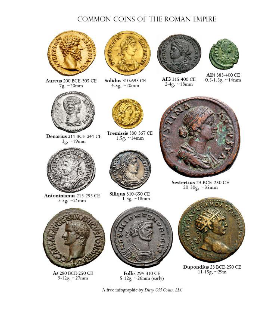

In [12]:
coins_2 = cv2.imread("coins_2.jpg")
show(coins_2)

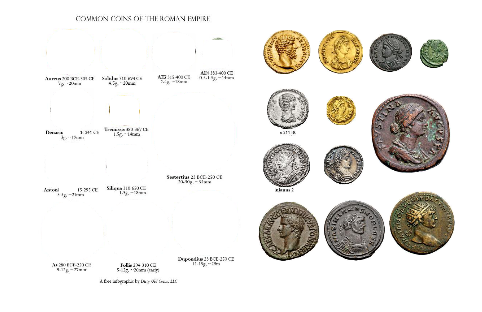

In [13]:
original = cv2.imread("coins_2.jpg", 0)
text = cv2.imread("coins_2.jpg")
coins = np.copy(text)
img = original
img = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)[1]
img = cv2.GaussianBlur(img, (7, 7), 3)
img = 255 - img
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((15, 15), dtype=np.uint8), iterations=3)
white = np.array([255, 255, 255]).astype(np.uint8)
w,h = img.shape[0], img.shape[1]
for x in range(w):
    for y in range(h):
        if img[x][y] > 10:
            text[x][y] = white 
        else:
            coins[x][y] = white

show(np.hstack((text, coins)))


**7. (11 баллов) ** Для каждого из зашумленных изображений $coins\_noize\_1.jpg$, $coins\_noize\_2.jpg$, $coins\_noize\_3.jpg$: выделите целые монеты, сгруппируйте их по размеру и посчитайте число монет в каждой группе. На выходе программа должна выдавать полученное число групп монет, средний размер монеты для каждой группы и число монет
в каждой группе, а также изображение, визуализирующее результат. На данном изображении на черном фоне должны быть цветом выделены области, соответствующие монетам. Монеты, принадлежащие одной группе, должны быть обозначены одним и тем же цветом.

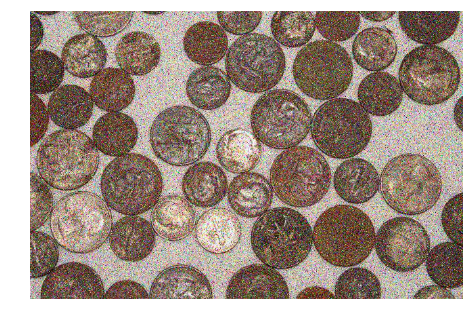

In [14]:
coins_noize_1 = cv2.imread("coins_noize_1.jpg")
show(coins_noize_1)

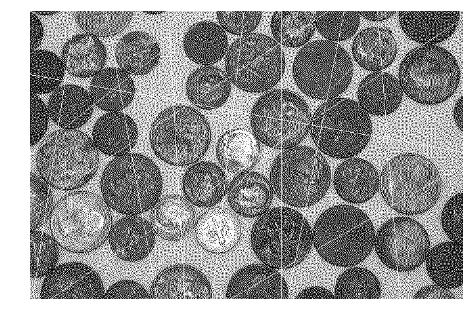

In [15]:
coins_noize_2 = cv2.imread("coins_noize_2.jpg")
show(coins_noize_2)

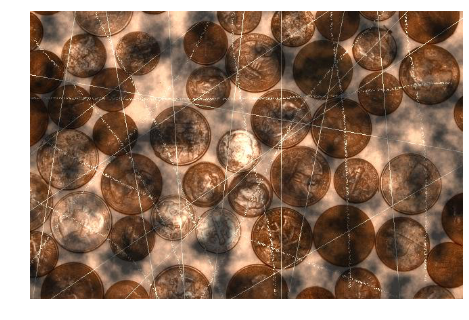

In [16]:
coins_noize_3 = cv2.imread("coins_noize_3.jpg")
show(coins_noize_3)

In [17]:
from collections import defaultdict

min_radius, max_radius = 30, 50
border = max_radius
distance_error = 10


def find_all_possible_circles(gray_img):
    w, h = gray_img.shape
    radiuses = np.zeros((w, h), np.uint8)
    t = cv2.copyMakeBorder(gray_img, border, border, border, border, cv2.BORDER_CONSTANT, value = 255)
    
    def test_circle(r, t):
        a,b = np.ogrid[-r:r,-r:r]
        mask = (a*a + b*b <= r*r) #  * (a*a + b*b >= (r-5)*(r-5))
        region = t[x+border-r:x+border+r,y+border-r:y+border+r][mask]
        return (region == 0).sum() < 80

    for x in range(0, w, 2):
        for y in range(0, h, 2):
            if gray_img[x][y] == 0:
                continue
            for r in range(min_radius, max_radius, 1):
                if test_circle(r, t):
                    radiuses[x][y] = r
                else:
                    break

    illustration = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    xs, ys, rs = np.array([], dtype=np.uint8), np.array([], dtype=np.uint8), np.array([], dtype=np.uint8)
    step = 20
    for x in range(0, w, step):
        for y in range(0, h, step):
            t = radiuses[x:x+step,y:y+step]
            m = t.max()
            if m != 0:
                tx, ty = np.where(t == m)
                xs = np.concatenate((xs, x + tx))
                ys = np.concatenate((ys, y + ty))
                rs = np.concatenate((rs, np.repeat(m, len(tx))))
                cv2.rectangle(illustration, (y, x), (y + step, x + step), (255, 0, 0), 1)
    circles = set()
    for x, y, r in zip(xs, ys, rs):
        cv2.circle(illustration, (y, x), r, (0, 0, 255), 2)
        circles.add((x, y, r))
        
    return circles, illustration

def filter_circles(gray_img, circles):
    def intersect(c1, c2):
        x1, y1, r1 = c1
        x2, y2, r2 = c2
        return (x1-x2)**2 + (y1-y2)**2 < (r1+r2-distance_error)**2
    illustration = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    good_circles = set()
    while circles:
        c = max(circles, key=lambda x: x[2])
        good_circles.add(c)
        copy = set([x for x in circles])
        for other in copy:
            if intersect(c, other):
                circles.remove(other)

    for x, y, r in good_circles:
        cv2.circle(illustration, (y, x), r, (0, 0, 255), 2)

    return good_circles, illustration


def group_coins(original, gray, coins):
    illustration = np.copy(original)
    w, h = gray.shape
    for x in range(w):
        for y in range(h):
            if gray[x][y] == 0:
                illustration[x][y] = np.array([0, 0, 0], dtype=np.uint8)
    get_r = lambda x: x[2]
    min_r, max_r = get_r(min(coins, key=get_r)), get_r(max(coins, key=get_r))
    delta = 3
    groups = defaultdict(list)
    for r in range(min_r, max_r + delta, delta):
        color = (randint(0, 255), randint(0, 255), randint(0, 255))
        for x, y, cr in filter(lambda x: (r <= get_r(x) < r + delta), coins):
            cv2.circle(illustration, (y, x), cr - 4, color, 4)
            groups[r].append(cr)
    return groups, illustration


def output(step1, step2, step3, step4, groups):
    images = [step1, step2, step3, step4]
    titles = ['remove noize + threshold', 'all possible circles', 'bigest circles', 'grouped coins']
    fig, axs = plt.subplots(nrows=4, figsize=(10,20))
    for i in range(len(images)):
        axs[i].axis('off')
        if images[i].ndim == 2:
            axs[i].imshow(images[i], cmap='gray')
        else:
            axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axs[i].set_title(titles[i])
    plt.show()

    print ("Coins: {}, groups of coins: {}".format(len(good_circles), len(groups)))
    for i, r in enumerate(groups):
        print ("Group {} - size:{}, avg. radius:{}".format(i + 1, len(groups[r]), str(np.average(groups[r]))))


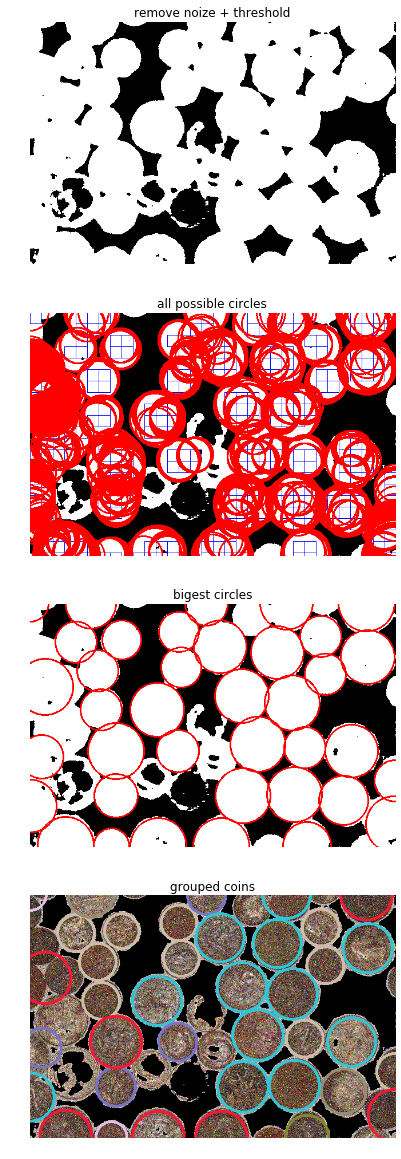

Coins: 38, groups of coins: 7
Group 1 - size:7, avg. radius:49.0
Group 2 - size:10, avg. radius:35.6
Group 3 - size:4, avg. radius:37.5
Group 4 - size:1, avg. radius:42.0
Group 5 - size:2, avg. radius:43.5
Group 6 - size:12, avg. radius:46.9166666667
Group 7 - size:2, avg. radius:31.5


In [18]:
original = coins_noize_1
img1 = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
img1 = cv2.medianBlur(img1, 9)
img1 = cv2.threshold(img1, 170, 255, cv2.THRESH_BINARY_INV)[1]
step1 = np.copy(img1)

circles, step2 = find_all_possible_circles(step1)
good_circles, step3 = filter_circles(step1, circles)
groups, step4 = group_coins(original, step1, good_circles)
output(step1, step2, step3, step4, groups)

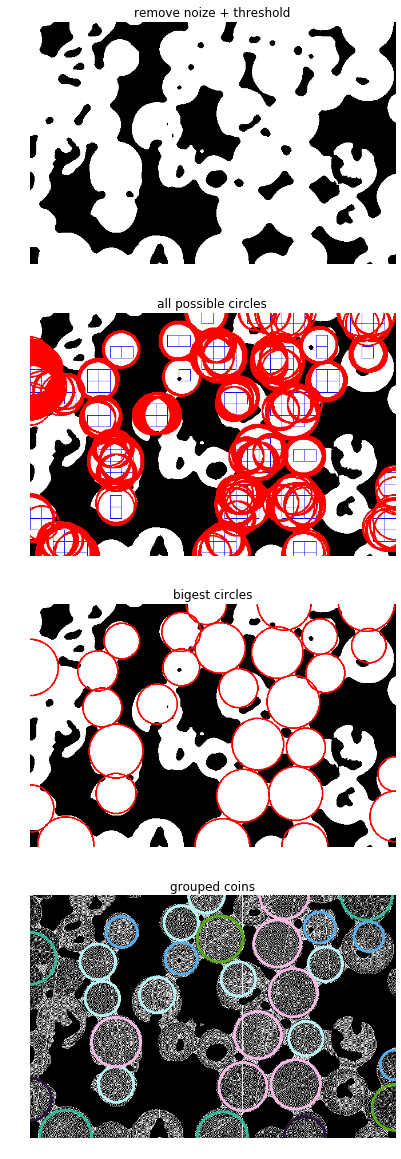

Coins: 29, groups of coins: 6
Group 1 - size:4, avg. radius:48.75
Group 2 - size:9, avg. radius:34.4444444444
Group 3 - size:2, avg. radius:40.5
Group 4 - size:2, avg. radius:44.0
Group 5 - size:7, avg. radius:46.1428571429
Group 6 - size:5, avg. radius:30.8


In [19]:
original = coins_noize_2
img1 = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
img1 = cv2.GaussianBlur(img1, (9, 9), 9)
img1 = cv2.medianBlur(img1, 15)
img1 = cv2.threshold(img1, 170, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
step1 = np.copy(img1)

circles, step2 = find_all_possible_circles(step1)
good_circles, step3 = filter_circles(step1, circles)
groups, step4 = group_coins(original, step1, good_circles)
output(step1, step2, step3, step4, groups)

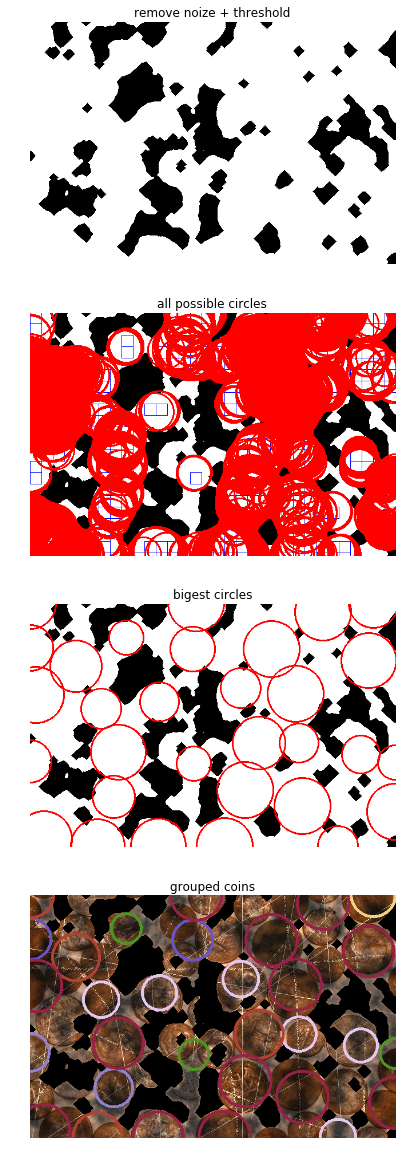

Coins: 31, groups of coins: 7
Group 1 - size:13, avg. radius:48.7692307692
Group 2 - size:6, avg. radius:34.3333333333
Group 3 - size:2, avg. radius:37.0
Group 4 - size:2, avg. radius:39.5
Group 5 - size:1, avg. radius:43.0
Group 6 - size:4, avg. radius:45.75
Group 7 - size:3, avg. radius:30.0


In [21]:
original = coins_noize_3
img1 = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
# img1 = cv2.GaussianBlur(img1, (3, 3), 3)
img1 = cv2.medianBlur(img1, 7)

img1 = cv2.threshold(img1, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
img1 = cv2.morphologyEx(img1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5)), iterations=4)

step1 = np.copy(img1)
circles, step2 = find_all_possible_circles(step1)
good_circles, step3 = filter_circles(step1, circles)
groups, step4 = group_coins(original, step1, good_circles)
output(step1, step2, step3, step4, groups)

**8. (5 баллов) ** Для каждого из зашумленных изображений $coins\_noize\_1.jpg$, $coins\_noize\_2.jpg$, $coins\_noize\_3.jpg$: задача аналогична предыдущей, только считать надо не только целые монеты, но и обрезанные краем изображения.

Да вроде, в предыдущей задаче сразу начал так решать.